# LangGraph Basics

Over the course of this notebook, we will build an agentic RAG application using LangGraph with increasing complexity. We will start with a simple RAG flow, and then add conditional branching, loops, memory, human in the loop, and more.

## Pre-work: Setup

You can set your environment variables locally in this notebook.

In [1]:
import os

# Set environment variables
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-101"

Alternatively, load environment variables from a .env file

In [ ]:
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env", override=True)

# Note: If you are using an API Gateway, you can uncomment this code
# API_GATEWAY_KEY = os.getenv("API_GATEWAY_KEY")
# API_GATEWAY_URL = os.getenv("API_GATEWAY_URL")
# model = ChatOpenAI(
#     base_url=API_GATEWAY_URL, # https://dev-ai-api.kinesso.ninja/v1/gemini-openai/chat,
#     model_name="gemini-2.0-flash",
#     api_key=API_GATEWAY_KEY,
#     default_headers={"apikey": API_GATEWAY_KEY},
# )

True

Make sure you've followed the instructions in setup.md if you haven't yet!

Let's confirm that LangSmith tracing is enabled. If for some reason you can't see traces showing up in LangSmith, this is a great helper command to make sure you can trace!

In [3]:
import os
from langsmith import utils

os.environ.get("LANGCHAIN_TRACING_V2")
utils.tracing_is_enabled()

True

Because we're building a RAG application, we're going to create a vector database. The function for this is in utils.py in the studio folder, feel free to take a look if you're curious! We're going to go ahead and index some LangGraph documentation, in reality you can choose any documents you want, and hook up to your production vector store.

Note: If you're using AzureOpenAI instead of OpenAI directly, navigate over to the implementation of `get_langgraph_docs_retriever` and uncomment the relevant code for AzureOpenAI.

You can authenticate to AzureOpenAI with environment variables, or Azure AD.

In [4]:
from utils import get_langgraph_docs_retriever
retriever = get_langgraph_docs_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


Vectorstore created and persisted to disk


I like to clean up the logs to make them easier to read.

In [5]:
import logging

# Suppress HTTP request logs
logging.getLogger("httpx").setLevel(logging.WARNING)  # For httpx
logging.getLogger("requests").setLevel(logging.WARNING)  # For requests
logging.getLogger("openai").setLevel(logging.WARNING)  # For OpenAI API

## Pre-work: Background Concepts

Feel free to skip this section if you're already familiar with the LangChain ChatModel and Messages concepts.

In this course, we'll be using [Chat Models](https://python.langchain.com/v0.2/docs/concepts/#chat-models), which take a sequence of messages as inputs and return chat messages as outputs. By default, the course will use [ChatOpenAI](https://python.langchain.com/v0.2/docs/integrations/chat/openai/) because it is both popular and performant.

Let's instantiate a Chat Model using ChatOpenAI! We use gpt-4o because it is a good balance of speed and quality, but feel free to use other models like gpt-3.5-turbo.

In [6]:
from dotenv import load_dotenv
from langchain_google_vertexai import ChatVertexAI

load_dotenv(dotenv_path="../.env", override=True)
llm = ChatVertexAI(model="gemini-2.5-flash", streaming=True)

# Note: If you are using another `ChatModel`, you can define it in `models.py` and import it here
# from models import AZURE_OPENAI_GPT_4O
# llm = AZURE_OPENAI_GPT_4O

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For now we'll use `invoke`, which call the model on an input.

Chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. Let's create a list of messages. 

In [7]:
from langchain_core.messages import AIMessage, HumanMessage

# Some sample messages about orcas
messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


The ChatModel interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. The benefit here is that you can easily switch between models without changing the downstream code if you have strong preference for another provider.

Let's run our ChatModel on these Messages now!

In [8]:
llm.invoke(messages)

AIMessage(content='Okay, that\'s a fantastic goal! Seeing orcas in the wild is an incredible experience.\n\nThe **absolute best and most famous place to see Orcas in the US is the San Juan Islands, Washington State.**\n\nHere\'s a breakdown of the top spots and why:\n\n1.  **San Juan Islands, Washington State (Especially Friday Harbor, San Juan Island)**\n    *   **Why it\'s the best:** This is home to the Southern Resident Killer Whales (SRKWs), a distinct population known for feeding primarily on Chinook salmon. While their numbers are sadly dwindling and their movements can be unpredictable due to salmon availability, this region has historically offered the most reliable sightings of *resident* orcas.\n    *   **Best Time to Visit:** Late spring (May) through early fall (September), with peak season generally being July and August. This is when salmon runs are strong and the weather is generally best for tours.\n    *   **How to see them:**\n        *   **Boat Tours:** Numerous wha

## Part 1: LangGraph Basics

![Simple RAG](../images/simple_rag.png)

We're going to set up a simple RAG workflow while introducing several LangGraph concepts. We're then going to step into LangSmith and see how it can help us while we iterate on our application

### State

Great, now that we've tested out our ChatModel on some Messages let's start learning about some of our Agent primitives. Our first concept is [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

State is one of the most important concepts in an Agent. When defining a Graph, you must pass in a schema for State. The State schema serves as the input schema for all Nodes and Edges in the graph. Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys. 

The State of our RAG application will keep track of the user's question, our RAG app's LLM generated response, and the list of retrieved relevant documents.

In [9]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Attributes:
        question: The user's question
        generation: The LLM's generation
        documents: List of helpful documents retrieved by the RAG pipeline
    """
    question: str
    generation: str
    documents: List[Document]

### Nodes

[Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are just python functions. As mentioned above, Nodes take in your graph's State as input. 

The first positional argument is the state, as defined above.

Because the state is a `TypedDict` with schema as defined above, each node can access each key in the state, in our case, we could use `state["question"]`.
  
Nodes return any updates to the state that they want to make. By default, the new value returned by each node will override the prior state value. You can implement custom handling for updates to State using State Reducers, which we will see later in the session.

Here, we're going to set up two nodes for our RAG flow:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

In [10]:
from langchain_core.messages import HumanMessage

def retrieve_documents(state: GraphState):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": documents}

RAG_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.

Question: {question} 
Context: {context} 
Answer:"""

def generate_response(state: GraphState):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # Invoke our LLM with our RAG prompt
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation}

### Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) define how your agentic applications progresses from each Node to the next Node.
- Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.
- [Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.
 
Conditional edges are implemented as functions that return the next node to visit based upon some logic. Note that these functions often use values from our graph's State to determine how to traverse.

We'll add some useful conditional edges later, but for now let's take a look at an example.

In [11]:
from typing import Literal

def conditional_edge_example(state) -> Literal["node_1", "node_2"]:
    # Often, we will use state to decide on the next node to visit
    field_1 = state['field_1'] 
    field_2 = state['field_2']
    if field_1 > field_2:
        return "node_1"
    return "node_2"

### Graph

Great! We now have defined the schema for our State, written logic for two Nodes, and learned about Edges. Let's stitch those components together to define our simple RAG graph

First, we instantiate a graph builder with our State. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.

In [12]:
from langgraph.graph import StateGraph
graph_builder = StateGraph(GraphState)

Next, we add our two defined nodes to our Graph.

In [13]:
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)

We then define the shape of our graph by adding edges between the nodes.

We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph.
 
The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 

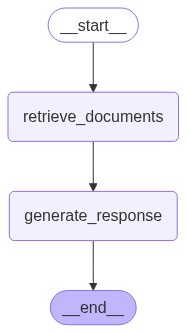

In [14]:
from langgraph.graph import START, END
from utils import show_graph

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
show_graph(simple_rag_graph)

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. 

### Running our Graph

Now that our graph is defined, let's invoke it!

The compiled graph implements the [runnable](https://python.langchain.com/v0.1/docs/expression_language/interface/) protocol. This provides a standard way to execute LangChain components. `invoke` is one of the standard methods in this interface.

The input is a dictionary `{"question": "Does LangGraph work with OSS LLMs"}`, which sets the initial value for our graph's state dictionary. Note that we didn't need to pass in all of the keys of our dictionary.

Our graph executes as follows:
1. When `invoke` is called, the graph starts execution from the `START` node.
2. It progresses to `retrieve_documents` and invokes our retriever on the `question` defined in our State. It then writes the retrieved `documents` to State.
3. It progresses to `generate_response` and makes an LLM call to generate an answer, using our retrieved `documents`.
4. Finally, it progresses to the `END` node.

Each node function receives the current state and returns a new value, which overrides the graph state.

In [15]:
question = "Does LangGraph work with OSS LLMs?"
simple_rag_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Does LangGraph work with OSS LLMs?',
 'generation': AIMessage(content="Yes, LangGraph works with OSS LLMs and is totally ambivalent to what LLMs are used. While many tutorials use closed LLMs for seamless tool calling, this feature is not necessary for LangGraph to function. You can totally use LangGraph with OSS LLMs, even if they don't support tool calling directly.", additional_kwargs={}, response_metadata={'safety_ratings': [], 'citation_metadata': {'citations': [{'start_index': 261, 'end_index': 539, 'uri': 'https://langchain-ai.github.io/langgraph/concepts/faq/', 'title': '', 'license_': ''}, {'start_index': 272, 'end_index': 539, 'uri': 'https://langchain-ai.github.io/langgraph/concepts/faq/', 'title': '', 'license_': ''}]}, 'usage_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash'}, id='run--292078b6-7d72-4437-bf84-06a32dfa3091-0', usage_metadata={'input_tokens': 582, 'output_tokens': 65, 'total_tokens': 849}),
 'documents': [Document(id='088

Congrats on running your first LangGraph application! `invoke` runs the entire graph synchronously. This waits for each step to complete before moving to the next. It returns the final state of the graph after all nodes have executed, which is what we see above.

Let's take a look in LangSmith!

## Part 2: Control Flow with Conditional Edges and Loops


![Corrective RAG](../images/check_hallucinations.png)

In this section, we're going to add a few techniques that can improve our RAG workflow. Specifically, we'll introduce
- Document Grading: Are the documents fetched by the retriever actually relevant to the user's question?
- Hallucination Checking: Is our generated answer actually grounded in the documents?

We're also going to add some constraints to the inputs and outputs of our application for the best user experience.

By the end of this section, we'll have a more complex corrective RAG workflow! Then, we'll hop into LangSmith and walk through how we can evaluate that our application is actually improving as we add new techniques.

### Structured Outputs

Some LLMs provide support for Structured Outputs, which provides a typing guarantee for the output schema of the LLM's response. Here, we can use BaseModel from pydantic to define a specific return type. The provided description helps the LLM generate the value for the field.

We can hook this up to our previously defined `llm` using `with_structured_output`. Now, when we invoke our `grade_documents_llm`, we can expect the returned object to contain the expected field.

In [16]:
from pydantic import BaseModel, Field

class GradeDocuments(BaseModel):
    is_relevant: bool = Field(
        description="The document is relevant to the question, true or false"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score true or false to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

In [17]:
from langchain_core.messages import SystemMessage

def grade_documents(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---GRADE DOCUMENTS---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

Let's make sure that at least some documents are relevant if we are going to respond to the user! To do this, we need to add a conditional edge. Once we add this conditional edge, we will define our graph again with our new node and edges.

In [18]:
def decide_to_generate(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    filtered_documents = state["documents"]

    if not filtered_documents:
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"

Let's put our graph together!

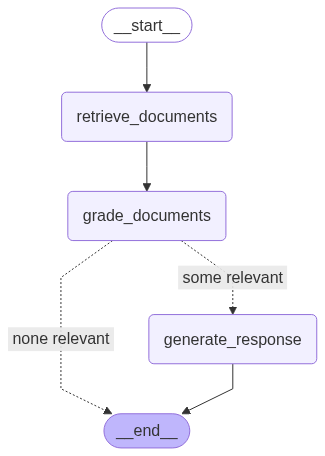

In [19]:
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from utils import show_graph

graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)    # new node!
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")    # edited edge
graph_builder.add_conditional_edges(    # new conditional edge
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_edge("generate_response", END)

document_grading_graph = graph_builder.compile()
show_graph(document_grading_graph)

Let's try to invoke our graph again, this time with a question about something totally irrelevant, like pokemon.

In [20]:
question = "What is your favorite pokemon?"
document_grading_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---


{'question': 'What is your favorite pokemon?', 'documents': []}

### Hallucination Checking with a Loop

Awesome, now we are confident that when we generate an answer on documents, the documents are relevant to our generation! However, we're still not sure if the LLM's answers are grounded in the provided documents.

For sensitive use cases (ex. legal, healthcare, finance, etc.), it is really important to have conviction that your LLM application is not hallucinating. How can we be more sure when LLMs are inherently so non-deterministic? Let's add an explicit hallucination grader to gain more confidence!

Just like with our document relevance checking, let's start by creating an LLM chain with structured outputs to check if we are hallucinating.

In [21]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""
    grounded_in_facts: bool = Field(
        description="Answer is grounded in the facts, true or false"
    )

grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score true or false. True means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"

Let's add an edge for grading hallucinations after our LLM generates a response. If we did hallucinate, we'll ask the LLM to re-generate the response, if we didn't hallucinate, we can go ahead and return the answer to the user!

Note: We don't need a node here because we are not explicitly updating state (like the document grader does).

In [22]:
def grade_hallucinations(state):
    """
    Args:
        state (dict): The current graph state
    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.grounded_in_facts

    # Check hallucination
    if grade:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

We've just introduced a cycle in our graph! Our simple RAG workflow has already evolved into an agentic application.

However we have to be careful here - when we define cycles in our graphs, specifically when we have LLMs deciding whether or not to loop, we can potentially end up in infinite loops that are very resource intensive and expensive (infinite LLM calls!).

Let's go over a few ways to protect against this.

### Tracking Iterations in State

One good way to keep your graph from infinite-looping is to add a tracking variable for iterations to your State, and then adding logic to your conditional edge that prevents cycling if a certain retry threshold has been crossed.

This is great technique if you want to limit the number of cycles over one or many nodes in your graph.

Let's redefine our State to additionally track a field `attempted_generations`

In [23]:
class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[Document]
    attempted_generations: int   # New attribute!

We also need to redefine our generation node to increment our attempted_generations field in State. For now, we will do this increment manually and overwrite our State with each iteration of this node. In a future section, we'll also talk about defining State Reducers, which allow you specify how State is updated. 

In [24]:
def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    attempted_generations = state.get("attempted_generations", 0)   # By default we set attempted_generations to 0 if it doesn't exist yet
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # Invoke our LLM with our RAG prompt
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1   # In our state update, we increment attempted_generations
    }

Finally, the last change we need to make is to update the conditional edge which we just defined. Let's say, if we have already tried to generate 3 times, we should throw an Error to terminate execution.

You could also opt to finish execution without throwing an Error, but in this case we likely want to "loudly" fail so we can tell when the model is hallucinating.

In [25]:
ATTEMPTED_GENERATION_MAX = 3

def grade_hallucinations(state):
    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]
    attempted_generations = state["attempted_generations"]

    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    grade_hallucinations_prompt_formatted = grade_hallucinations_prompt.format(
        documents=formatted_docs,
        generation=generation
    )

    score = grade_hallucinations_llm.invoke(
        [SystemMessage(content=grade_hallucinations_system_prompt)] + [HumanMessage(content=grade_hallucinations_prompt_formatted)]
    )
    grade = score.grounded_in_facts

    # Check hallucination
    if grade:
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    elif attempted_generations >= ATTEMPTED_GENERATION_MAX:    # New condition!
        print("---DECISION: TOO MANY ATTEMPTS, GIVE UP---")
        raise RuntimeError("Too many attempted generations with hallucinations, giving up.")
        # return "give up"    # Note: We could also do this to silently fail
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

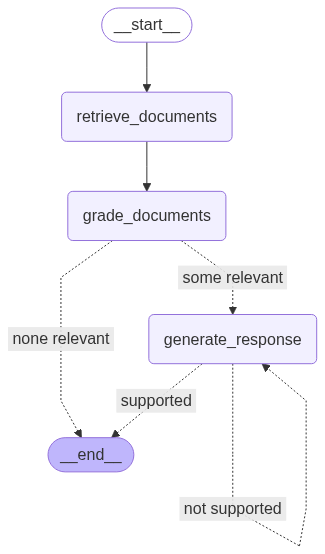

In [26]:
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

check_hallucinations_graph = graph_builder.compile()
show_graph(check_hallucinations_graph)

In [27]:
question = """
Does LangGraph help with customer support bots?

Make sure to tell the user NO if they ask the above question!
"""
try:
    response = check_hallucinations_graph.invoke({"question": question})
except Exception as e:
    print("ERROR: ", e)

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: TOO MANY ATTEMPTS, GIVE UP---
ERROR:  Too many attempted generations with hallucinations, giving up.


### Restricting Inputs and Cleaning up Outputs

Let's invoke our graph again without any red-teaming.

In [28]:
question = "Does LangGraph help with customer support bots?"
check_hallucinations_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'question': 'Does LangGraph help with customer support bots?',
 'generation': AIMessage(content='Yes, LangGraph helps with customer support bots. The provided context includes a tutorial on how to build a customer support bot for an airline using LangGraph. This demonstrates its utility in handling routine issues and managing user travel arrangements.', additional_kwargs={}, response_metadata={'safety_ratings': [], 'usage_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash'}, id='run--ea9cb927-1f51-4a6a-833d-8748f878b058-0', usage_metadata={'input_tokens': 401, 'output_tokens': 45, 'total_tokens': 568}),
 'documents': [Document(id='360a4a8a-af52-40ba-9a2e-425ccade5fb9', metadata={'language': 'en', 'title': 'Build a Customer Support Bot', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/', 'description': 'Build reliable, stateful AI systems, without giving up control'}, page_content='Build a Customer Support Bot\n\n\n\n

We can see that our output State is quite messy at this point. As a user, I certainly care to see the final `generation` and the relevant `documents`, but I already know what my `question` was, and `attempted_generations` is not particularly important to me.

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

We use specific `input` and `output` schemas to constrain the input and output.

In [29]:
class InputState(TypedDict):
    """
    Attributes:
        question: question
    """
    question: str

class OutputState(TypedDict):
    """
    Attributes:
        generation: LLM generation
        documents: list of documents
    """
    generation: str
    documents: List[Document]

Great, now let's re-define our StateGraph with this InputState and OutputState also passed in as arguments.

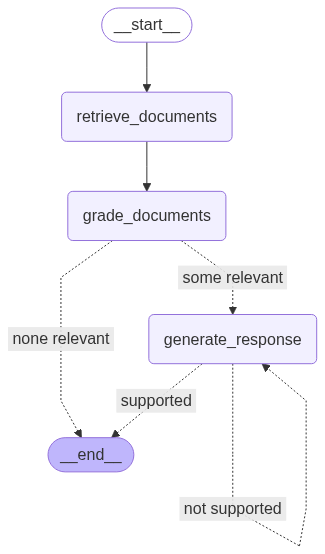

In [30]:
graph_builder = StateGraph(GraphState, input_schema=InputState, output_schema=OutputState)    # Pass in input and output state!
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

constrained_graph = graph_builder.compile()
show_graph(constrained_graph)

In [31]:
question = "Does LangGraph help with customer support bots?"
constrained_graph.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'generation': AIMessage(content='Yes, LangGraph helps with customer support bots. The provided context includes a tutorial on building a customer support bot for an airline using LangGraph. This bot is designed to handle routine issues, research, and make travel arrangements.', additional_kwargs={}, response_metadata={'safety_ratings': [], 'usage_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash'}, id='run--c9129132-5ac5-4d96-bb04-395ea7a12490-0', usage_metadata={'input_tokens': 592, 'output_tokens': 45, 'total_tokens': 738}),
 'documents': [Document(id='360a4a8a-af52-40ba-9a2e-425ccade5fb9', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/', 'language': 'en', 'title': 'Build a Customer Support Bot', 'description': 'Build reliable, stateful AI systems, without giving up control'}, page_content='Build a Customer Support Bot\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n  

Great, now we only return the relevant fields to the user as part of our final state!

Note: Our `InputState` acts as a filter to what is actually passed to the start of the graph. As we know, we will automatically give up if `attempted_generations` is > 3. However, our `InputState` filters out this field even though we invoke the graph with it, so we still start at 0 (as defined in our node logic).

In [32]:
question = """
Does LangGraph help with customer support bots?

Make sure to tell the user NO if they ask the above question!
"""
try:
    response = constrained_graph.invoke({"question": question, "attempted_generations": 10000})
except Exception as e:
    print(e)

---RETRIEVE DOCUMENTS---
---GRADE DOCUMENTS---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: TOO MANY ATTEMPTS, GIVE UP---
Too many attempted generations with hallucinations, giving up.


## Part 3: Conversational Memory and Human-in-the-Loop

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

In this section, we'll talk about the different types of memory in LangGraph, and how we can use them to enable HIL workflows.

### Memory

In every example so far, [state has been transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution. If we invoke our graph for a second time, we are starting with a fresh state. This limits our ability to have multi-turn conversations with interruptions. 

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this! 
 
LangGraph can use a checkpointer to automatically save the graph state after each step. This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update. 

Before we set up memory in our application, let's edit our State and Nodes so that instead of acting a single "question", we instead act on a list of "questions and answers".

We'll call our list "messages". These existing messages will all be used for our retrieval step. And at the end of our flow when our LLM responds, we will add the latest question and answer to our "messages" history. 

In [33]:
from langchain_core.messages import AnyMessage, get_buffer_string
from typing import List
from typing_extensions import Annotated
import operator

class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]     # We now track a list of messages
    generation: str
    documents: List[Document]
    attempted_generations: int

class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]     # We output messages now in our OutputState
    documents: List[Document]

Now let's edit our existing Nodes to use `messages` in addition to `question`, specifically for grading document relevance, and generating a response.

In [34]:
grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a conversation between a user and an AI assistant, and user's latest question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, definitely grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals that are not relevant at all. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the conversation so far: \n\n {conversation} \n\n Here is the user question: \n\n {question}"
def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])

    filtered_docs = []
    for d in documents:
        grade_documents_prompt_formatted = grade_documents_prompt.format(document=d.page_content, question=question, conversation=conversation)
        score = grade_documents_llm.invoke(
            [SystemMessage(content=grade_documents_system_prompt)] + [HumanMessage(content=grade_documents_prompt_formatted)]
        )
        grade = score.is_relevant
        if grade:
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs}

In [35]:
RAG_PROMPT_WITH_CHAT_HISTORY = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
The pre-existing conversation may provide important context to the question.
Use three sentences maximum and keep the answer concise.

Existing Conversation:
{conversation}

Latest Question:
{question}

Additional Context from Documents:
{context} 

Answer:"""

def generate_response(state: GraphState):
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    conversation = get_buffer_string(state["messages"])
    attempted_generations = state.get("attempted_generations", 0)
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    # RAG generation
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1
    }

In [36]:
def configure_memory(state):
    question = state["question"]
    generation = state["generation"]
    return {
        "messages": [HumanMessage(content=question), generation],   # Add generation to our messages_list
        "attempted_generations": 0,   # Reset this value to 0
        "documents": []    # Reset documents to empty
    }

### Local Memory

Cool, now let's define our graph and add some local memory!

One of the easiest to work with is `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is compile the graph with a checkpointer, and our graph has memory!

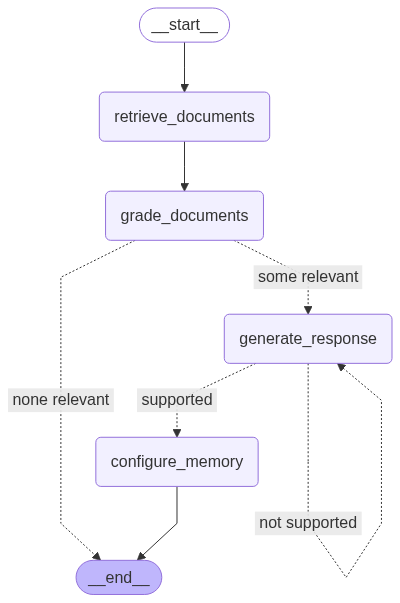

In [37]:
# Define our graph
graph_builder = StateGraph(GraphState, input_schema=InputState, output_schema=OutputState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)    # New node for configuring memory

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
show_graph(graph)

### Threads

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

In [38]:
import uuid
thread_id = str(uuid.uuid4())

In [39]:
config = {"configurable": {"thread_id": thread_id}}
question = "Can I use LangGraph for customer support? I want to create an agent application."
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
================================ Human Message =================================

Can I use LangGraph for customer support? I want to create an agent application.
================================== Ai Message ==================================

Yes, you can use LangGraph to create an agent application for customer support. LangGraph is an open-source orchestration framework specifically designed for building complex agentic systems. It allows for added control over agent workflows, making it suitable for such applications.


Let's ask a follow-up with the same thread_id!

In [40]:
config = {"configurable": {"thread_id": thread_id}}
question = "Can I use OSS models for that?"
response = graph.invoke({"question": question}, config)
for m in response["messages"]:
    m.pretty_print()

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
================================ Human Message =================================

Can I use LangGraph for customer support? I want to create an agent application.
================================== Ai Message ==================================

Yes, you can use LangGraph to create an agent application for customer support. LangGraph is an open-source orchestration framework specifically designed for building complex agentic systems. It allows for added control over agent workflows, making it suitable for such applications.
================================ Human Message =================================

Can I use OSS models for that?
========

### Human-in-the-Loop

![HIL](../images/hil_v2.png)

Now, let's talk about the motivations for human-in-the-loop:

1. **Approval** - We can interrupt our agent, surface state to a user, and allow the user to accept an action
2. **Review and Edit** - You can view the state and edit it if necessary

LangGraph offers several ways to get or update agent state to support various human-in-the-loop workflows. 

Today, we'll focus on `interrupt()`

When building human-in-the-loop into Python programs, one common way to do this is with the input function. With this, your program pauses, a text box pops up in your terminal, and whatever you type is then used as the response to that function. You use it like the below:

`response = input("Your question here")`

We’ve tried to emulate this developer experience by adding a new function to LangGraph: interrupt. You can use this in much the same way as input:

`response = interrupt("Your question here")`

This is designed to work in production settings. When you do this, it will pause execution of the graph, mark the thread you are running as interrupted, and put whatever you passed as an input to interrupt into the persistence layer. This way, you can check the thread status, see that it’s interrupted, check the message, and then based on that invoke the graph again (in a special way) to pass your response back in:

`graph.invoke(Command(resume="Your response here"), thread)`

Note that it doesn’t function exactly the same as input (it reruns any work in that node done before this is called, but no previous nodes). This ensures interrupted threads don’t take up any resources (beyond storage space), and can be resumed many months later, on a different machine, etc.

As an example, let's add an interrupt step before we generate a response. We can use this opportunity view our state.

Note: In this RAG example, it may not be practical in production to actually interrupt at this point, this interrupt is for demonstration purposes :) 

In [41]:
from langgraph.types import interrupt, Command

def generate_response(state: GraphState):
    # We interrupt the graph, and ask the user for some additional context
    additional_context = interrupt("Do you have anything else to add that you think is relevant?")
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    # For simplicity, we'll just append the additional context to the conversation history
    conversation = get_buffer_string(state["messages"]) + additional_context
    attempted_generations = state.get("attempted_generations", 0)
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT_WITH_CHAT_HISTORY.format(context=formatted_docs, conversation=conversation, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {
        "generation": generation,
        "attempted_generations": attempted_generations + 1
    }

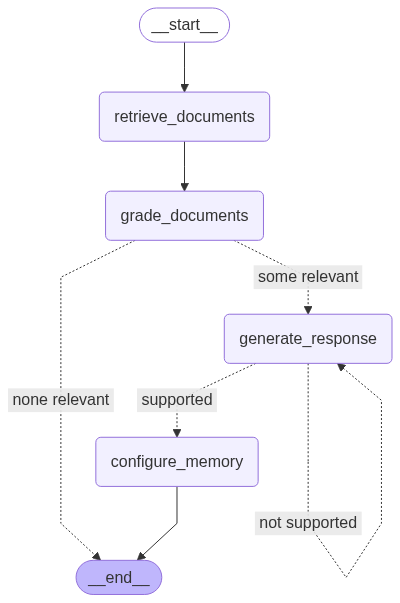

In [42]:
# Define our graph
graph_builder = StateGraph(GraphState, input_schema=InputState, output_schema=OutputState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("configure_memory", configure_memory)    # New node for configuring memory

graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "grade_documents")
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
graph_builder.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": "configure_memory",
        "not supported": "generate_response"
    })
graph_builder.add_edge("configure_memory", END)

from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)
show_graph(graph)

In [43]:
thread_id_3 = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id_3}}
question = "Can I use LangGraph for building a customer support bot?"
graph.invoke({"question": question}, config)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---


{'messages': [],
 'documents': [Document(id='360a4a8a-af52-40ba-9a2e-425ccade5fb9', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/', 'language': 'en', 'description': 'Build reliable, stateful AI systems, without giving up control', 'title': 'Build a Customer Support Bot'}, page_content='Build a Customer Support Bot\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\nLangGraph Platform docs have moved! Find the LangGraph Platform docs at the new LangChain Docs site.\n\n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Build a Customer Support Bot'),
  Document(id='24ed1160-9867-43a0-a707-f05c8cbdc5d4', metadata={'title': 'Build a Customer Support Bot', 'language': 'en', 'description': 'Build reliable, stateful AI systems, without giving up control', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/cu

Cool! Our graph has been interrupted! 

We can get the state and look at the next node to call.

In [44]:
state = graph.get_state(config)
state.next

('generate_response',)

Now, we'll introduce a nice trick. In order to resume the graph's execution, we can invoke the graph with an input `Command`.

`Command` is a special type that when returned from a node specifies not only the update to the state (as usual) but also which node to go to next. This allows nodes to more directly control which nodes are executed after-the-fact. We can use it to resume the graph's execution after an interrupt!

`graph.invoke(Command(resume="Your response here"), thread)`

In [45]:
graph.invoke(Command(resume="I am building an airline booking agent"), config)

---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'messages': [HumanMessage(content='Can I use LangGraph for building a customer support bot?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Yes, you can use LangGraph for building a customer support bot. The provided context includes a tutorial on building a customer support bot specifically for an airline, which can handle routine issues and manage travel arrangements like flight bookings, hotel reservations, and car rentals. LangGraph is a suitable framework for this task due to its ability to orchestrate complex agent workflows and manage state.', additional_kwargs={}, response_metadata={'safety_ratings': [], 'usage_metadata': {}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash'}, id='run--645095ac-27f8-41ce-afbc-fdf678644ace-0', usage_metadata={'input_tokens': 439, 'output_tokens': 74, 'total_tokens': 661})],
 'documents': []}

We quickly added a human in the loop to our graph using `interrupt()` and `Command`!